In [7]:
# import libraries

import pandas as pd
import datetime
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

In [ ]:
# reads imported excel

df = pd.read_excel(r"C:\workspace\Maroon Capital\MSFT.xlsx")

In [65]:
# numerifies dates

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object
df['Date'] = df['Date'].apply(str_to_datetime)

KeyError: 'Date'

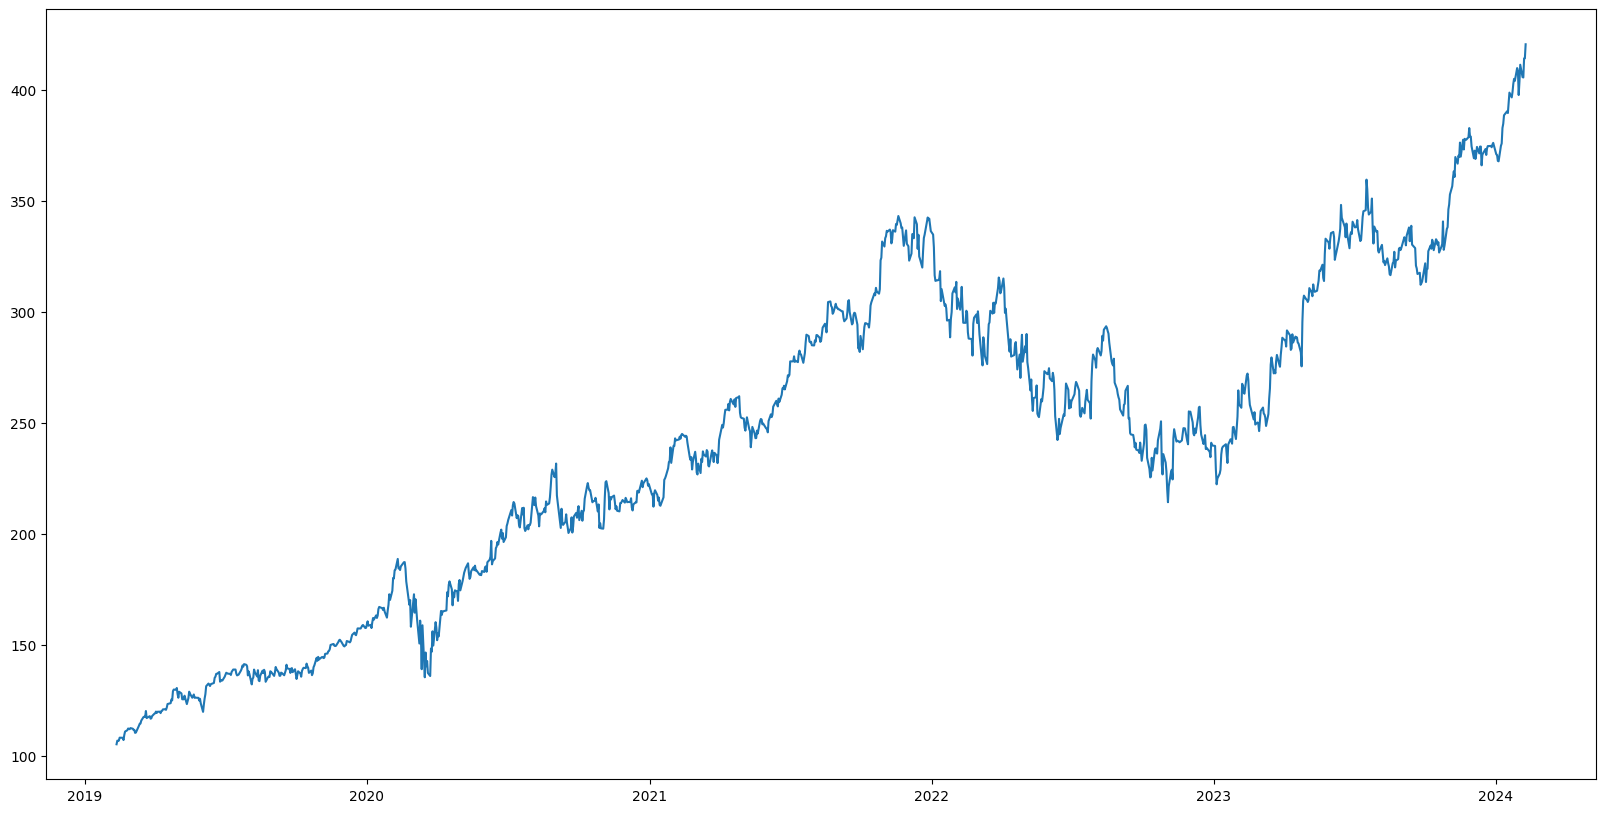

In [64]:
# original data trends

plt.figure(figsize = (20, 10))
plt.plot(df['Close'])

In [54]:
# creates dataset

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=20):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2020-03-25', 
                                '2022-03-23', 
                                n=20)

In [63]:
# dataset

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [56]:
# splits dataset to train, dev, test sets

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [57]:
# 4-layered neural network

model = Sequential([layers.Input((20, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 6s 130ms/step - loss: 55799.5898 - mean_absolute_error: 232.9805 - val_loss: 110302.8438 - val_mean_absolute_error: 332.0424
Epoch 2/100
13/13 [==============================] - 0s 32ms/step - loss: 55249.6758 - mean_absolute_error: 231.7888 - val_loss: 109566.0234 - val_mean_absolute_error: 330.9310
Epoch 3/100
13/13 [==============================] - 0s 20ms/step - loss: 54382.5117 - mean_absolute_error: 229.9118 - val_loss: 107678.5234 - val_mean_absolute_error: 328.0668
Epoch 4/100
13/13 [==============================] - 0s 18ms/step - loss: 52855.9219 - mean_absolute_error: 226.5699 - val_loss: 104983.1016 - val_mean_absolute_error: 323.9327
Epoch 5/100
13/13 [==============================] - 0s 15ms/step - loss: 50406.0195 - mean_absolute_error: 221.0648 - val_loss: 100285.7578 - val_mean_absolute_error: 316.5992
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 46493.0039 - mean_absolute_error: 212.06

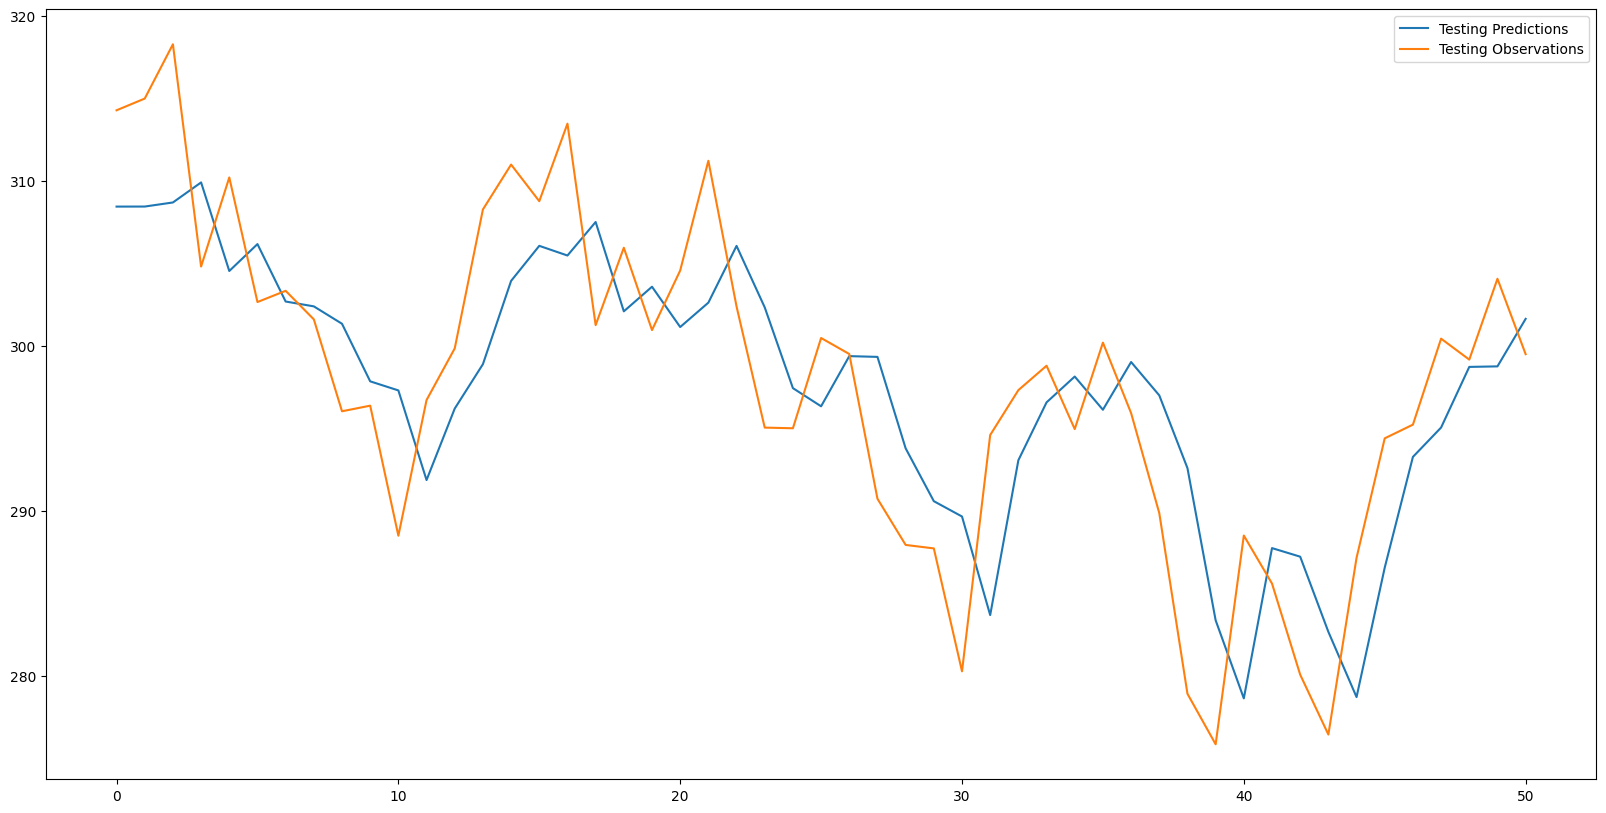

In [61]:
# visualization of test results

test_predictions = model.predict(X_test).flatten()
plt.figure(figsize = (20, 10))
plt.plot(test_predictions)
plt.plot( y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])